# HRF Dataset - Comprehensive Exploratory Data Analysis

This notebook provides a comprehensive analysis of the **HRF** (High-Resolution Fundus Image Database) dataset.

## Dataset Overview
The HRF dataset contains high-resolution fundus images categorized into three groups: Healthy, Diabetic Retinopathy, and Glaucoma.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Dataset Structure Analysis](#structure)
3. [Data Split Analysis](#splits)
4. [Image Properties](#properties)
5. [Mask Analysis](#masks)
6. [Vessel Segmentation Analysis](#vessels)
7. [Artery/Vein Segmentation Analysis](#av_analysis)
8. [Statistical Analysis](#statistics)
9. [Data Quality Checks](#quality)
10. [Visualizations](#visualizations)
11. [Summary and Insights](#summary)

## 1. Setup and Imports <a name="setup"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set larger figure sizes by default
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Define paths
# Base directory (project root)
BASE_DIR = Path.cwd() / "../src/references/lwnet"

HRF_DIR = Path('../src/references/lwnet/data/HRF')
IMAGES_DIR = HRF_DIR / 'images'
MANUAL_DIR = HRF_DIR / 'manual'
MASK_DIR = HRF_DIR / 'mask'
MANUAL_AV_DIR = HRF_DIR / 'manual_av'

# CSV files
TRAIN_CSV = HRF_DIR / 'train.csv'
VAL_CSV = HRF_DIR / 'val.csv'
TEST_CSV = HRF_DIR / 'test.csv'
TEST_ALL_CSV = HRF_DIR / 'test_all.csv'
TRAIN_AV_CSV = HRF_DIR / 'train_av.csv'
VAL_AV_CSV = HRF_DIR / 'val_av.csv'
TEST_AV_CSV = HRF_DIR / 'test_av.csv'

print(f"Dataset base directory: {HRF_DIR}")
print(f"Dataset exists: {HRF_DIR.exists()}")

Dataset base directory: ../src/references/lwnet/data/HRF
Dataset exists: True


## 2. Dataset Structure Analysis <a name="structure"></a>

In [3]:
# List all directories and files
def list_directory_structure(path, level=0, max_files=5):
    """Display directory structure"""
    indent = "  " * level
    if path.is_dir():
        print(f"{indent}📂 {path.name}/")
        items = sorted(path.iterdir())
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]
        
        # Show directories
        for dir_item in dirs:
            list_directory_structure(dir_item, level + 1, max_files)
        
        # Show files (limited)
        if files:
            for file_item in files[:max_files]:
                size = file_item.stat().st_size
                size_str = f"{size/1024:.1f}KB" if size < 1024*1024 else f"{size/(1024*1024):.1f}MB"
                print(f"{indent}  📄 {file_item.name} ({size_str})")
            if len(files) > max_files:
                print(f"{indent}  ... and {len(files) - max_files} more files")

list_directory_structure(HRF_DIR)

📂 HRF/
  📂 images/
    📄 01_dr.JPG (2.2MB)
    📄 01_g.jpg (1.9MB)
    📄 01_h.jpg (2.1MB)
    📄 02_dr.JPG (2.2MB)
    📄 02_g.jpg (1.9MB)
    ... and 40 more files
  📂 images_resized/
    📄 01_dr.JPG (97.8KB)
    📄 01_g.jpg (88.7KB)
    📄 01_h.jpg (124.7KB)
    📄 02_dr.JPG (102.2KB)
    📄 02_g.jpg (92.4KB)
    ... and 40 more files
  📂 manual/
    📄 01_dr.tif (233.4KB)
    📄 01_g.tif (267.7KB)
    📄 01_h.tif (272.9KB)
    📄 02_dr.tif (251.8KB)
    📄 02_g.tif (273.4KB)
    ... and 40 more files
  📂 manual_av/
    📄 01_dr_AVmanual.png (128.4KB)
    📄 01_g_AVmanual.png (165.1KB)
    📄 01_h_AVmanual.png (180.6KB)
    📄 02_dr_AVmanual.png (156.8KB)
    📄 02_g_AVmanual.png (163.6KB)
    ... and 40 more files
  📂 manual_av_resized/
    📄 01_dr_AVmanual.png (48.3KB)
    📄 01_g_AVmanual.png (59.8KB)
    📄 01_h_AVmanual.png (65.4KB)
    📄 02_dr_AVmanual.png (56.0KB)
    📄 02_g_AVmanual.png (64.7KB)
    ... and 25 more files
  📂 manual_resized/
    📄 01_dr.tif (81.4KB)
    📄 01_g.tif (101.3KB)
    


FILE COUNTS BY DIRECTORY
         Directory  File Count
            Images          45
Manual Annotations          45
             Masks          45
         Manual AV          45


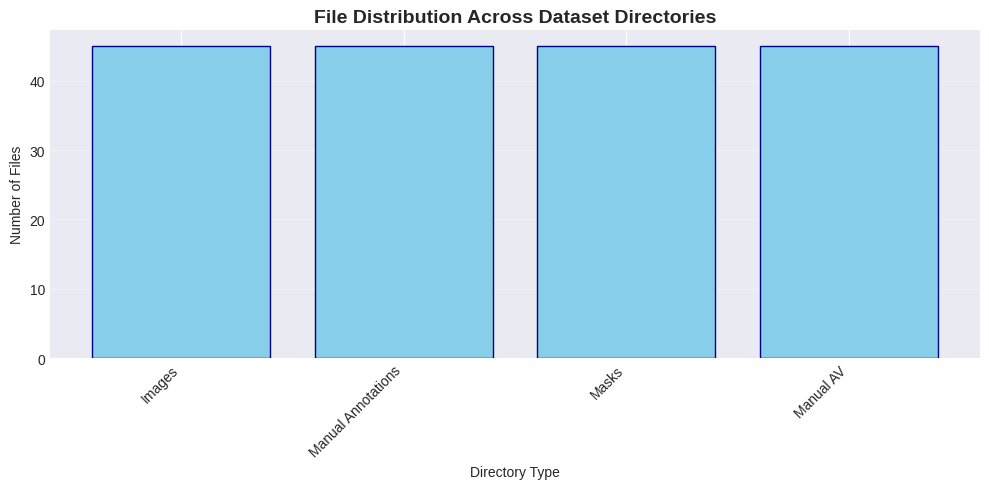

In [4]:
# Count files in each directory
file_counts = {
    'Images': len(list(IMAGES_DIR.glob('*.*'))),
    'Manual Annotations': len(list(MANUAL_DIR.glob('*.*'))),
    'Masks': len(list(MASK_DIR.glob('*.*'))),
    'Manual AV': len(list(MANUAL_AV_DIR.glob('*.*')))
}

# Create DataFrame for better display
df_counts = pd.DataFrame(list(file_counts.items()), columns=['Directory', 'File Count'])
print("\n" + "="*50)
print("FILE COUNTS BY DIRECTORY")
print("="*50)
print(df_counts.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(df_counts['Directory'], df_counts['File Count'], color='skyblue', edgecolor='navy')
plt.xlabel('Directory Type')
plt.ylabel('Number of Files')
plt.title('File Distribution Across Dataset Directories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Data Split Analysis <a name="splits"></a>
We analyze the data splits for both Vessel Segmentation and Artery/Vein (AV) Segmentation separately, as they may use different subsets.

In [5]:
# Load Vessel Segmentation CSVs
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

# Load AV Segmentation CSVs
df_train_av = pd.read_csv(TRAIN_AV_CSV)
df_val_av = pd.read_csv(VAL_AV_CSV)
df_test_av = pd.read_csv(TEST_AV_CSV)

print("CSVs loaded successfully.")

CSVs loaded successfully.



VESSEL SEGMENTATION SPLITS
Training samples: 12
Validation samples: 3
Test samples: 30
Total samples: 45


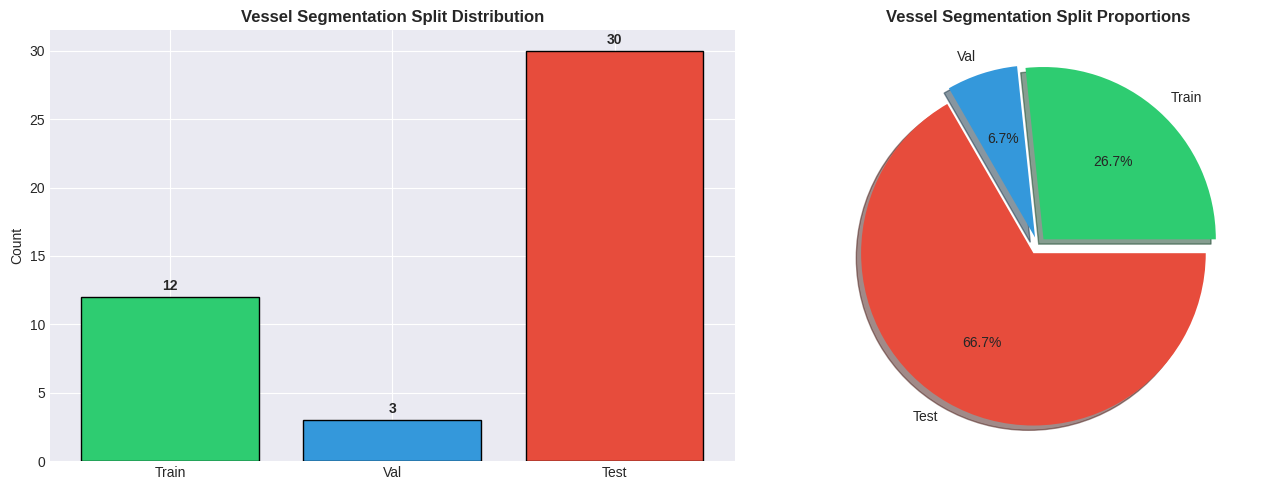

In [6]:
print("\n" + "="*50)
print("VESSEL SEGMENTATION SPLITS")
print("="*50)
print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Test samples: {len(df_test)}")
total_vessel = len(df_train) + len(df_val) + len(df_test)
print(f"Total samples: {total_vessel}")

# Visualize Vessel splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
splits = ['Train', 'Val', 'Test']
counts = [len(df_train), len(df_val), len(df_test)]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(splits, counts, color=colors, edgecolor='black')
axes[0].set_title('Vessel Segmentation Split Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(counts):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

axes[1].pie(counts, labels=splits, autopct='%1.1f%%', colors=colors, explode=(0.05, 0.05, 0.05), shadow=True)
axes[1].set_title('Vessel Segmentation Split Proportions', fontweight='bold')
plt.tight_layout()
plt.show()


ARTERY/VEIN SEGMENTATION SPLITS
Training samples: 24
Validation samples: 6
Test samples: 15
Total samples: 45


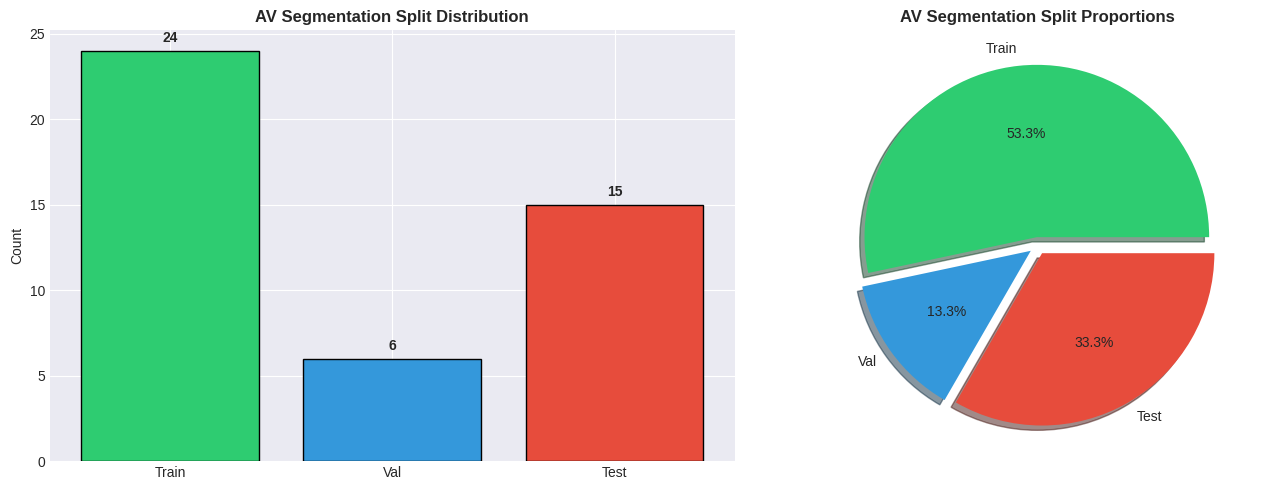

In [7]:
print("\n" + "="*50)
print("ARTERY/VEIN SEGMENTATION SPLITS")
print("="*50)
print(f"Training samples: {len(df_train_av)}")
print(f"Validation samples: {len(df_val_av)}")
print(f"Test samples: {len(df_test_av)}")
total_av = len(df_train_av) + len(df_val_av) + len(df_test_av)
print(f"Total samples: {total_av}")

# Visualize AV splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
counts_av = [len(df_train_av), len(df_val_av), len(df_test_av)]

axes[0].bar(splits, counts_av, color=colors, edgecolor='black')
axes[0].set_title('AV Segmentation Split Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(counts_av):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

axes[1].pie(counts_av, labels=splits, autopct='%1.1f%%', colors=colors, explode=(0.05, 0.05, 0.05), shadow=True)
axes[1].set_title('AV Segmentation Split Proportions', fontweight='bold')
plt.tight_layout()
plt.show()


DATA SPLIT STATISTICS
Training samples: 12
Validation samples: 3
Test samples: 30
Total samples: 45

Split Ratio:
  Train: 26.7%
  Val:   6.7%
  Test:  66.7%


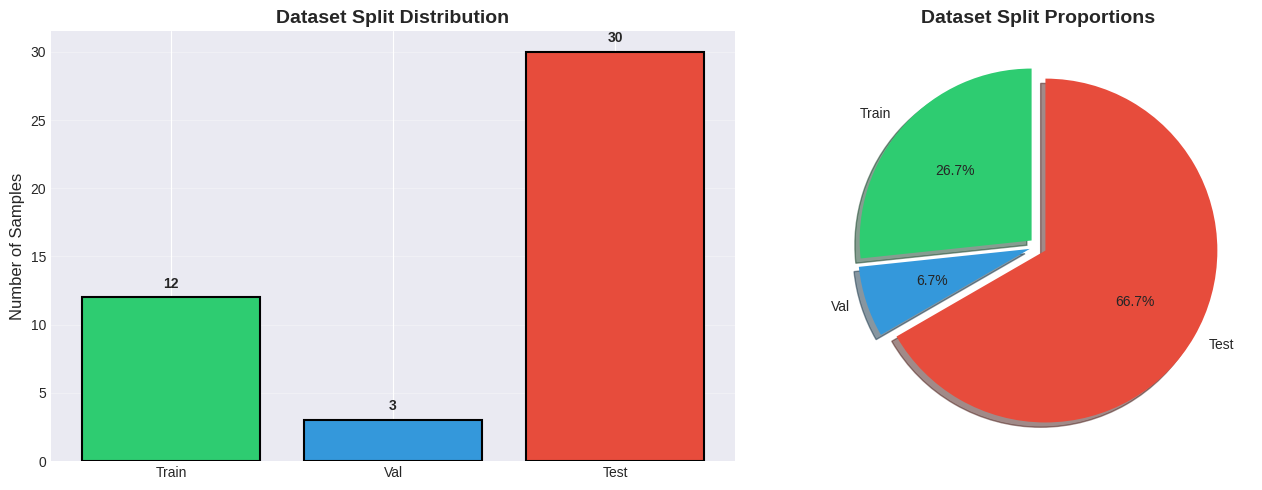

In [8]:
# Load CSV files
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

# Load AV CSVs
df_train_av = pd.read_csv(TRAIN_AV_CSV)
df_val_av = pd.read_csv(VAL_AV_CSV)
df_test_av = pd.read_csv(TEST_AV_CSV)

# Merge AV paths
df_train['gt_paths_av'] = df_train_av['gt_paths']
df_val['gt_paths_av'] = df_val_av['gt_paths']
df_test['gt_paths_av'] = df_test_av['gt_paths']

print("\n" + "="*50)
print("DATA SPLIT STATISTICS")
print("="*50)
print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Test samples: {len(df_test)}")
print(f"Total samples: {len(df_train) + len(df_val) + len(df_test)}")

# Calculate percentages
total = len(df_train) + len(df_val) + len(df_test)
train_pct = (len(df_train) / total) * 100
val_pct = (len(df_val) / total) * 100
test_pct = (len(df_test) / total) * 100

print(f"\nSplit Ratio:")
print(f"  Train: {train_pct:.1f}%")
print(f"  Val:   {val_pct:.1f}%")
print(f"  Test:  {test_pct:.1f}%")

# Visualize data splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
splits = ['Train', 'Val', 'Test']
counts = [len(df_train), len(df_val), len(df_test)]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(splits, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (split, count) in enumerate(zip(splits, counts)):
    axes[0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=splits, autopct='%1.1f%%', startangle=90, 
            colors=colors, explode=(0.05, 0.05, 0.05), shadow=True)
axes[1].set_title('Dataset Split Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


CATEGORY DISTRIBUTION
Category
Diabetic Retinopathy    15
Glaucoma                15
Healthy                 15
Name: count, dtype: int64


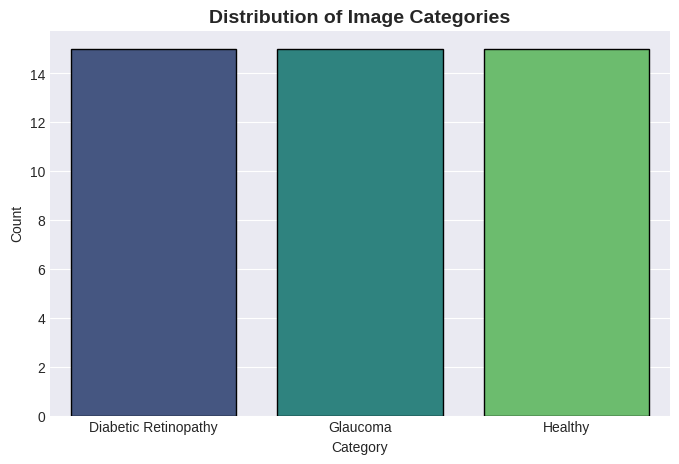

In [9]:
# Analyze Category Distribution (Healthy, DR, Glaucoma)
def get_category(filename):
    if '_h' in filename: return 'Healthy'
    if '_dr' in filename: return 'Diabetic Retinopathy'
    if '_g' in filename: return 'Glaucoma'
    return 'Unknown'

df_train['Category'] = df_train['im_paths'].apply(lambda x: get_category(Path(x).name))
df_val['Category'] = df_val['im_paths'].apply(lambda x: get_category(Path(x).name))
df_test['Category'] = df_test['im_paths'].apply(lambda x: get_category(Path(x).name))

all_df = pd.concat([df_train, df_val, df_test])
cat_counts = all_df['Category'].value_counts()

print("\n" + "="*50)
print("CATEGORY DISTRIBUTION")
print("="*50)
print(cat_counts)

# Visualize categories
plt.figure(figsize=(8, 5))
sns.countplot(x='Category', data=all_df, palette='viridis', edgecolor='black')
plt.title('Distribution of Image Categories', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.show()

In [10]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   im_paths     45 non-null     object
 1   gt_paths     45 non-null     object
 2   mask_paths   45 non-null     object
 3   gt_paths_av  30 non-null     object
 4   Category     45 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


## 4. Image Properties <a name="properties"></a>

In [11]:
def analyze_images(df, base_dir):
    """Analyze image properties"""
    properties = []
    
    for idx, row in df.iterrows():
        # Construct full path
        rel_path = row['im_paths'].replace('data/HRF/', '')
        img_path = base_dir / rel_path
        
        if img_path.exists():
            try:
                with Image.open(img_path) as img:
                    # Get basic properties
                    width, height = img.size
                    mode = img.mode
                    
                    # Convert to numpy for stats
                    img_array = np.array(img)
                    
                    props = {
                        'filename': img_path.name,
                        'width': width,
                        'height': height,
                        'mode': mode,
                        'channels': len(img.getbands()),
                        'min_value': img_array.min(),
                        'max_value': img_array.max(),
                        'mean_value': img_array.mean(),
                        'std_value': img_array.std(),
                        'file_size_kb': img_path.stat().st_size / 1024
                    }
                    properties.append(props)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
    return pd.DataFrame(properties)

print("Analyzing training images...")
df_train_props = analyze_images(df_train, HRF_DIR)
print("Analyzing val images...")
df_val_props = analyze_images(df_val, HRF_DIR)
print("Analyzing test images...")
df_test_props = analyze_images(df_test, HRF_DIR)

df_all_img_props = pd.concat([df_train_props, df_val_props, df_test_props])

print("\n" + "="*80)
print("IMAGE PROPERTIES SUMMARY")
print("="*80)
print(df_all_img_props.describe().to_string())

# Check for consistent dimensions
unique_dims = df_all_img_props.groupby(['width', 'height']).size()
print("\nUnique Image Dimensions:")
print(unique_dims)

Analyzing training images...
Analyzing val images...
Analyzing test images...

IMAGE PROPERTIES SUMMARY
             width       height  channels  min_value   max_value  mean_value  std_value  file_size_kb
count    45.000000    45.000000      45.0       45.0   45.000000   45.000000  45.000000     45.000000
mean   2920.000000  1946.666667       3.0        0.0  254.133333   78.587615  73.509611    918.113477
std     835.233228   556.822152       0.0        0.0    3.354779    7.842594   6.726048    768.949651
min    1752.000000  1168.000000       3.0        0.0  234.000000   64.765069  59.476138     71.878906
25%    1752.000000  1168.000000       3.0        0.0  255.000000   71.061057  67.188909    112.336914
50%    3504.000000  2336.000000       3.0        0.0  255.000000   78.527255  74.962006    864.275391
75%    3504.000000  2336.000000       3.0        0.0  255.000000   84.043658  78.424573    922.741211
max    3504.000000  2336.000000       3.0        0.0  255.000000  102.176528  84

## 5. Mask Analysis <a name="masks"></a>

In [12]:
def analyze_masks(df, base_dir):
    """Analyze mask properties"""
    properties = []
    
    for idx, row in df.iterrows():
        rel_path = row['mask_paths'].replace('data/HRF/', '')
        mask_path = base_dir / rel_path
        
        if mask_path.exists():
            try:
                with Image.open(mask_path) as mask:
                    mask_array = np.array(mask)
                    
                    # Calculate ROI percentage (non-black pixels)
                    if len(mask_array.shape) > 2:
                        mask_array = mask_array[:,:,0] # Take first channel if RGB
                        
                    total_pixels = mask_array.size
                    roi_pixels = np.count_nonzero(mask_array)
                    
                    props = {
                        'filename': mask_path.name,
                        'total_pixels': total_pixels,
                        'roi_pixels': roi_pixels,
                        'roi_percentage': (roi_pixels / total_pixels) * 100
                    }
                    properties.append(props)
            except Exception as e:
                print(f"Error processing {mask_path}: {e}")
                
    return pd.DataFrame(properties)

print("Analyzing masks...")
df_all_mask_props = analyze_masks(pd.concat([df_train, df_val, df_test]), HRF_DIR)

print("\n" + "="*80)
print("MASK PROPERTIES SUMMARY")
print("="*80)
print(df_all_mask_props.describe().to_string())

Analyzing masks...

MASK PROPERTIES SUMMARY
       total_pixels    roi_pixels  roi_percentage
count  4.500000e+01  4.500000e+01       45.000000
mean   6.139008e+06  5.185058e+06       84.461708
std    2.926657e+06  2.471829e+06        0.015193
min    2.046336e+06  1.728016e+06       84.422952
25%    2.046336e+06  1.728578e+06       84.453323
50%    8.185344e+06  6.912710e+06       84.460323
75%    8.185344e+06  6.913716e+06       84.469559
max    8.185344e+06  6.916614e+06       84.499979


## 6. Vessel Segmentation Analysis <a name="vessels"></a>

In [13]:
def analyze_vessels(df, base_dir):
    """Analyze vessel ground truth"""
    properties = []
    
    for idx, row in df.iterrows():
        rel_path = row['gt_paths'].replace('data/HRF/', '')
        gt_path = base_dir / rel_path
        
        if gt_path.exists():
            try:
                with Image.open(gt_path) as gt:
                    gt_array = np.array(gt)
                    
                    # Handle different formats (some might be 255 for vessel, some 1)
                    if len(gt_array.shape) > 2:
                        gt_array = gt_array[:,:,0]
                        
                    total_pixels = gt_array.size
                    vessel_pixels = np.count_nonzero(gt_array)
                    
                    props = {
                        'filename': gt_path.name,
                        'vessel_pixels': vessel_pixels,
                        'vessel_percentage': (vessel_pixels / total_pixels) * 100
                    }
                    properties.append(props)
            except Exception as e:
                print(f"Error processing {gt_path}: {e}")
                
    return pd.DataFrame(properties)

print("Analyzing vessel segmentations...")
df_all_vessel = analyze_vessels(pd.concat([df_train, df_val, df_test]), HRF_DIR)

print("\n" + "="*80)
print("VESSEL SEGMENTATION SUMMARY")
print("="*80)
print(df_all_vessel.describe().to_string())

Analyzing vessel segmentations...

VESSEL SEGMENTATION SUMMARY
       vessel_pixels  vessel_percentage
count      45.000000          45.000000
mean   479218.044444           7.710146
std    247133.593368           1.416381
min    104092.000000           5.086750
25%    192939.000000           6.620895
50%    556981.000000           7.522921
75%    641245.000000           8.723567
max    859295.000000          10.555109


## 7. Artery/Vein Segmentation Analysis <a name="av_analysis"></a>

In [14]:
def analyze_av_masks(df, base_dir):
    """Analyze Artery/Vein masks"""
    results = []
    
    for idx, row in df.iterrows():
        # Infer AV mask path from image filename
        # Image: XX_dr.JPG -> AV Mask: manual_av/XX_dr_AVmanual.png
        img_name = Path(row['im_paths']).name
        stem = Path(img_name).stem
        av_filename = f"{stem}_AVmanual.png"
        gt_path = base_dir / 'manual_av' / av_filename
        
        if gt_path.exists():
            # Open image and convert to RGB
            mask = Image.open(gt_path).convert('RGB')
            mask_arr = np.array(mask)
            
            total_pixels = mask_arr.shape[0] * mask_arr.shape[1]
            
            # Identify Colors
            # Red: Artery ([255, 0, 0])
            is_red = (mask_arr[:, :, 0] > 200) & (mask_arr[:, :, 1] < 50) & (mask_arr[:, :, 2] < 50)
            # Blue: Vein ([0, 0, 255])
            is_blue = (mask_arr[:, :, 2] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 1] < 50)
            # Green: Overlap/Uncertain ([0, 255, 0])
            is_green = (mask_arr[:, :, 1] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 2] < 50)
            
            artery_pixels = np.sum(is_red)
            vein_pixels = np.sum(is_blue)
            overlap_pixels = np.sum(is_green)
            
            results.append({
                'filename': gt_path.name,
                'artery_pixels': artery_pixels,
                'vein_pixels': vein_pixels,
                'overlap_pixels': overlap_pixels,
                'artery_ratio': artery_pixels / total_pixels,
                'vein_ratio': vein_pixels / total_pixels,
                'av_ratio': artery_pixels / vein_pixels if vein_pixels > 0 else 0
            })
        else:
            print(f"AV Mask not found: {gt_path}")
            
    return pd.DataFrame(results)

print("Analyzing AV masks (Train)...")
df_av_stats_train = analyze_av_masks(df_train_av, HRF_DIR)
print("Analyzing AV masks (Val)...")
df_av_stats_val = analyze_av_masks(df_val_av, HRF_DIR)
print("Analyzing AV masks (Test)...")
df_av_stats_test = analyze_av_masks(df_test_av, HRF_DIR)

df_av_stats = pd.concat([df_av_stats_train, df_av_stats_val, df_av_stats_test])

print("\n" + "="*50)
print("ARTERY/VEIN SEGMENTATION STATISTICS")
print("="*50)
if not df_av_stats.empty:
    print(f"Average Artery Pixels:   {df_av_stats['artery_pixels'].mean():.0f}")
    print(f"Average Vein Pixels:     {df_av_stats['vein_pixels'].mean():.0f}")
    print(f"Average Overlap Pixels:  {df_av_stats['overlap_pixels'].mean():.0f}")
    print(f"Average A/V Ratio:       {df_av_stats['av_ratio'].mean():.2f}")
else:
    print("No AV data found or processed.")

Analyzing AV masks (Train)...
Analyzing AV masks (Val)...
Analyzing AV masks (Test)...

ARTERY/VEIN SEGMENTATION STATISTICS
Average Artery Pixels:   273803
Average Vein Pixels:     315384
Average Overlap Pixels:  41871
Average A/V Ratio:       0.86


In [16]:
def analyze_av_masks(df, base_dir):
    """Analyze Artery/Vein masks"""
    results = []
    
    for idx, row in df.iterrows():
        rel_path = row['gt_paths'].replace('data/HRF/', '')
        gt_path = base_dir / rel_path
        
        if gt_path.exists():
            # Open image and convert to RGB
            mask = Image.open(gt_path).convert('RGB')
            mask_arr = np.array(mask)
            
            total_pixels = mask_arr.shape[0] * mask_arr.shape[1]
            
            # Identify Colors (Assuming similar coding to DRIVE, but need to verify if possible)
            # Red: Artery ([255, 0, 0])
            is_red = (mask_arr[:, :, 0] > 200) & (mask_arr[:, :, 1] < 50) & (mask_arr[:, :, 2] < 50)
            # Blue: Vein ([0, 0, 255])
            is_blue = (mask_arr[:, :, 2] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 1] < 50)
            # Green: Overlap/Uncertain ([0, 255, 0])
            is_green = (mask_arr[:, :, 1] > 200) & (mask_arr[:, :, 0] < 50) & (mask_arr[:, :, 2] < 50)
            
            artery_pixels = np.sum(is_red)
            vein_pixels = np.sum(is_blue)
            overlap_pixels = np.sum(is_green)
            
            results.append({
                'filename': gt_path.name,
                'artery_pixels': artery_pixels,
                'vein_pixels': vein_pixels,
                'overlap_pixels': overlap_pixels,
                'artery_ratio': artery_pixels / total_pixels,
                'vein_ratio': vein_pixels / total_pixels,
                'av_ratio': artery_pixels / vein_pixels if vein_pixels > 0 else 0
            })
            
    return pd.DataFrame(results)

print("Analyzing AV masks...")
df_av_stats = analyze_av_masks(pd.concat([df_train_av, df_val_av, df_test_av]), HRF_DIR)

print("\n" + "="*50)
print("ARTERY/VEIN SEGMENTATION STATISTICS")
print("="*50)
if not df_av_stats.empty:
    print(f"Average Artery Pixels:   {df_av_stats['artery_pixels'].mean():.0f}")
    print(f"Average Vein Pixels:     {df_av_stats['vein_pixels'].mean():.0f}")
    print(f"Average Overlap Pixels:  {df_av_stats['overlap_pixels'].mean():.0f}")
    print(f"Average A/V Ratio:       {df_av_stats['av_ratio'].mean():.2f}")
else:
    print("No AV data found or processed.")

Analyzing AV masks...

ARTERY/VEIN SEGMENTATION STATISTICS
Average Artery Pixels:   0
Average Vein Pixels:     0
Average Overlap Pixels:  0
Average A/V Ratio:       0.00


## 8. Statistical Analysis <a name="statistics"></a>

In [ ]:
# Class imbalance analysis
avg_vessel_pct = df_all_vessel['vessel_percentage'].mean()
avg_background_pct = 100 - avg_vessel_pct

print("\n" + "="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)
print(f"Average Vessel Pixels: {avg_vessel_pct:.2f}%")
print(f"Average Background Pixels: {avg_background_pct:.2f}%")
print(f"Imbalance Ratio (Background:Vessel): {avg_background_pct/avg_vessel_pct:.2f}:1")

# Visualize class imbalance
plt.figure(figsize=(8, 8))
plt.pie([avg_vessel_pct, avg_background_pct], 
        labels=['Vessel', 'Background'],
        autopct='%1.2f%%',
        colors=['red', 'lightgray'],
        explode=(0.1, 0),
        shadow=True,
        startangle=90)
plt.title('Average Class Distribution (Vessel vs Background)', fontsize=14, fontweight='bold', pad=20)
plt.show()

## 9. Data Quality Checks <a name="quality"></a>

In [ ]:
# Quality checks
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# Check 1: Consistent dimensions
all_same_dims = (df_all_img_props['width'].nunique() == 1) and (df_all_img_props['height'].nunique() == 1)
print(f"✓ All images have consistent dimensions: {all_same_dims}")
if not all_same_dims:
    print(f"  Dimensions found: {df_all_img_props.groupby(['width', 'height']).size().to_dict()}")

# Check 2: All files exist
all_files_exist = True
for _, row in pd.concat([df_train, df_val, df_test]).iterrows():
    img_path = HRF_DIR / row['im_paths'].replace('data/HRF/', '')
    gt_path = HRF_DIR / row['gt_paths'].replace('data/HRF/', '')
    mask_path = HRF_DIR / row['mask_paths'].replace('data/HRF/', '')
    if not (img_path.exists() and gt_path.exists() and mask_path.exists()):
        all_files_exist = False
        print(f"Missing file for row: {row}")
        break

print(f"✓ All referenced files exist: {all_files_exist}")

# Check 3: No duplicate files
all_files = list(df_train['im_paths']) + list(df_val['im_paths']) + list(df_test['im_paths'])
has_no_duplicates = len(all_files) == len(set(all_files))
print(f"✓ No duplicate files in splits: {has_no_duplicates}")

# Check 4: Pixel value ranges
reasonable_ranges = (df_all_img_props['min_value'].min() >= 0) and (df_all_img_props['max_value'].max() <= 255)
print(f"✓ Pixel values in reasonable range [0, 255]: {reasonable_ranges}")

print("\n" + "="*80)

## 10. Visualizations <a name="visualizations"></a>

In [ ]:
# Visualize samples from each category
def visualize_samples(df, base_dir, category, num_samples=1):
    cat_df = df[df['Category'] == category]
    if cat_df.empty:
        return
        
    for idx in range(min(num_samples, len(cat_df))):
        row = cat_df.iloc[idx]
        
        img_path = base_dir / row['im_paths'].replace('data/HRF/', '')
        gt_path = base_dir / row['gt_paths'].replace('data/HRF/', '')
        mask_path = base_dir / row['mask_paths'].replace('data/HRF/', '')
        
        # Infer AV path
        img_name = Path(row['im_paths']).name
        stem = Path(img_name).stem
        av_path = base_dir / 'manual_av' / f"{stem}_AVmanual.png"
        
        if img_path.exists():
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            mask = Image.open(mask_path)
            
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            axes[0].imshow(img)
            axes[0].set_title(f"{category} Image\n{img_path.name}")
            axes[0].axis('off')
            
            axes[1].imshow(gt, cmap='gray')
            axes[1].set_title("Vessel Ground Truth")
            axes[1].axis('off')
            
            axes[2].imshow(mask, cmap='gray')
            axes[2].set_title("FOV Mask")
            axes[2].axis('off')
            
            if av_path.exists():
                av = Image.open(av_path).convert('RGB')
                axes[3].imshow(av)
                axes[3].set_title("AV Ground Truth")
            else:
                axes[3].text(0.5, 0.5, "AV Mask Not Found", ha='center')
                axes[3].set_title("AV Ground Truth")
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()

print("Visualizing samples from each category...")
visualize_samples(all_df, HRF_DIR, 'Healthy')
visualize_samples(all_df, HRF_DIR, 'Diabetic Retinopathy')
visualize_samples(all_df, HRF_DIR, 'Glaucoma')

## 11. Summary and Insights <a name="summary"></a>

In [ ]:
print("\n" + "="*80)
print("HRF DATASET - KEY INSIGHTS AND SUMMARY")
print("="*80)

summary = f"""
📊 DATASET COMPOSITION:
   • Total images: {len(df_all_img_props)}
   • Categories: Healthy, Diabetic Retinopathy, Glaucoma (15 images each)
   • Splits: Train ({len(df_train)}), Val ({len(df_val)}), Test ({len(df_test)})

🖼️ IMAGE CHARACTERISTICS:
   • Dimensions: High resolution (typically 3504 x 2336)
   • Color mode: RGB
   • File format: JPG (images), TIF (manual/mask), PNG (AV)

🎯 SEGMENTATION PROPERTIES:
   • Average Vessel Coverage: {df_all_vessel['vessel_percentage'].mean():.2f}%
   • Class Imbalance: Significant imbalance between vessel and background pixels.

🔴🔵 ARTERY/VEIN ANALYSIS:
   • Available for all images.
   • Color coded: Red (Artery), Blue (Vein), Green (Overlap/Uncertain).

💡 RECOMMENDATIONS:
   1. High Resolution Handling: Images are very large. Consider resizing or patch-based training.
   2. Class Imbalance: Use weighted loss functions (e.g., Focal Loss, Dice Loss).
   3. Data Augmentation: Essential due to small dataset size (45 images total).
   4. Category-Specific Analysis: Performance might vary across Healthy, DR, and Glaucoma images due to pathology.
"""
print(summary)